In [1]:

import autofit as af
from warm_pixels import hst_utilities as ut, PixelLine

pixel_line_dict = {
    "location": [
        13,
        0
    ],
    "date": 2453963.758414352,
    "background": 31.30540652532858,
    "flux": 1760.68,
    "data": [
        52.64056497616352,
        48.48841447972527,
        49.40091619555943,
        48.330892024903015,
        47.84054545587673,
        49.30878150582641,
        48.7121868929113,
        49.20193282738758,
        48.38848720733444,
        47.789888907267816,
        46.1216780158082,
        47.62116196030635,
        2316.1096385003216,
        52.00117416910645,
        47.39681472247756,
        49.04053644125149,
        50.73253979945862,
        48.887028747158176,
        49.761016613247854,
        50.582789329908614,
        49.89475223938497,
        47.96562226593793,
        48.13477786554208,
        51.41839400253888,
        49.58684465281521
    ],
    "noise": [
        1.7182103404229303,
        1.1166195237573258,
        1.2968256178459387,
        0.972655469471766,
        0.6973247704784217,
        0.9908904439992736,
        1.14339830068772,
        1.3159924814976593,
        0.859036863542967,
        0.8633995566280004,
        0.40491942438735434,
        0.7045832874622435,
        6.9356449752906215,
        0.8668206366957554,
        0.4286787210661135,
        0.9599202153163372,
        1.4048511101130459,
        0.6924283058142602,
        1.1834516970981601,
        1.1475066293762684,
        0.9786730064496794,
        0.9350281902071158,
        0.8393195956710766,
        1.3560323220866162,
        1.2543348504815965
    ],
    "trail": {
        "background": 49.3402666264456,
        "flux": 2316.1096385003216,
        "data": [
            4.380012208800096,
            1.2751367066693575,
            1.250647533983674,
            2.3440525921241786,
            -0.31490408022940386,
            1.0488297203365562,
            1.2740078240822044,
            2.054206783508242,
            -0.3652697589650842,
            -1.2661383300173554,
            2.9299795228136105,
            -3.0537203233483083
        ],
        "noise": [
            1.1170566794808299,
            0.5896822755866629,
            1.2910869893846777,
            1.6466787708935813,
            1.487041751280432,
            1.6455751557981426,
            1.516125105811378,
            1.2016915948262423,
            1.3491984208319159,
            1.544737539771388,
            1.7566054819963581,
            2.12734639658636
        ]
    }
}

pixel_line = PixelLine.from_dict(pixel_line_dict)
date = pixel_line_dict["date"]

In [2]:
from warm_pixels.fit.model import TrailModel

# CCD
beta = 0.478
w = 84700.0
# Trap species
a = 0.17
b = 0.45
c = 0.38
# Trap lifetimes before or after the temperature change
if date < ut.date_T_change:
    tau_a = 0.48
    tau_b = 4.86
    tau_c = 20.6
else:
    tau_a = 0.74
    tau_b = 7.70
    tau_c = 37.0

# CCD
rho_q = af.UniformPrior(
    lower_limit=0.0,
    upper_limit=10.0,
)
beta = af.GaussianPrior(
    mean=0.478,
    sigma=0.1,
)
# w = af.GaussianPrior(
#     mean=84700.0,
#     sigma=20000,
# )
# # Trap species
# a = af.UniformPrior(
#     lower_limit=0.0,
#     upper_limit=1.0,
# )
# b = af.UniformPrior(
#     lower_limit=0.0,
#     upper_limit=1.0,
# )
# c = 1 - (a + b)
#
# tau_a = af.GaussianPrior(
#     mean=tau_a,
#     sigma=0.2,
# )
# tau_b = af.GaussianPrior(
#     mean=tau_b,
#     sigma=2.0,
# )
# tau_c = af.GaussianPrior(
#     mean=tau_c,
#     sigma=10.0,
# )

model = af.Model(
    TrailModel,
    rho_q=rho_q,
    beta=beta,
    w=w,
    a=a,
    b=b,
    c=c,
    tau_a=tau_a,
    tau_b=tau_b,
    tau_c=tau_c,
)

model.add_assertion(c > 0.0)

2022-10-10 09:56:14,092 - autofit.non_linear.abstract_search - INFO - Creating search
2022-10-10 09:56:14,132 - root - INFO - Starting search
2022-10-10 09:56:14,133 - root - INFO - Saving path info
2022-10-10 09:56:14,134 - root - INFO - Not complete. Starting non-linear search.
2022-10-10 09:56:14,135 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-10-10 09:56:14,163 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


231it [00:00, 261.57it/s, +50 | bound: 2 | nc: 1 | ncall: 2161 | eff(%): 13.003 | loglstar:   -inf < -20.115 <    inf | logz: -21.830 +/-  0.206 | dlogz:  0.001 >  0.059]

2022-10-10 09:56:15,064 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).



231it [00:00, 100350.52it/s, +50 | bound: 2 | nc: 1 | ncall: 2161 | eff(%): 13.003 | loglstar:   -inf < -20.115 <    inf | logz: -21.830 +/-  0.206 | dlogz:  0.001 >  0.059]

2022-10-10 09:56:15,083 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-10-10 09:56:15,096 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


2022-10-10 09:56:17,213 - root - INFO - Removing zip file


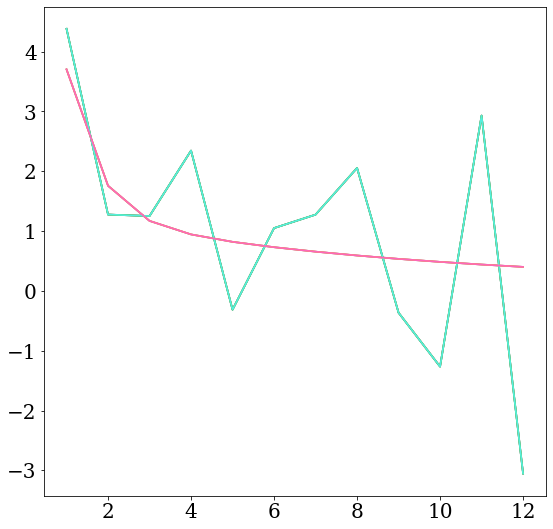

In [3]:
from warm_pixels.fit.analysis import Analysis
from matplotlib import pyplot as plt

"""
We make an instance of the analysis, passing it the data and associated variables.
"""

analysis = Analysis(
    pixel_line=pixel_line,
)
plt.plot(analysis.x, analysis.y)

"""
We make our optimiser which we can configure
"""

dynesty = af.DynestyStatic()

"""
Optimisation is performed by passing the model and the analysis to the fit function
"""

result = dynesty.fit(
    model=model,
    analysis=analysis,
)

In [5]:
"""
The log likelihood and best parametrisation can be found from the result
"""

print(f"log likelihood = {result.log_likelihood}")

best_trail_model = result.instance

print(f"rho_q = {best_trail_model.rho_q}")
print(f"beta = {best_trail_model.beta}")

log likelihood = -20.11483288451997
rho_q = 8.34020535815762
beta = 0.41554290399722216
